## Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- matplotlib
- The Python standard library
- Jupyter notebooks and nbdev

In [ ]:
#export
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl
import matplotlib.pyplot as plt

## Get data

In [ ]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [ ]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [ ]:
!ls -l data

total 231580
-rw-r--r-- 1 jhoward jhoward 220080342 Sep 27 17:34 mnist.pkl
-rw-r--r-- 1 jhoward jhoward  17051982 Sep 27 17:26 mnist.pkl.gz


This approach is a bit inconvenient because we'd like to have a progressbar while it's downloading, automatically figure out the filename, and automatically avoid re-downloading if it's already done. Ideally we'd also handle decompressing compressed files automatically too. [fastdownload](https://www.fast.ai/posts/2021-08-02-fastdownload.html) provides this functionality for us, so we'll use that in the future.

In [ ]:
with gzip.open(path_gz, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [ ]:
lst1 = list(x_train[0])
vals = lst1[200:210]
vals

[0.0,
 0.0,
 0.0,
 0.19140625,
 0.9296875,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125,
 0.98828125]

In [ ]:
def chunks(x, sz):
    for i in range(0, len(x), sz): yield x[i:i+sz]

In [ ]:
list(chunks(vals, 5))

[[0.0, 0.0, 0.0, 0.19140625, 0.9296875],
 [0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]]

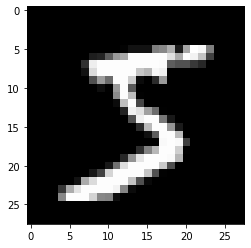

In [ ]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(list(chunks(lst1, 28)));

[islice](https://docs.python.org/3/library/itertools.html#itertools.islice)

In [ ]:
from itertools import islice

In [ ]:
it = iter(vals)
islice(it, 5)

<itertools.islice>

In [ ]:
list(islice(it, 5))

[0.0, 0.0, 0.0, 0.19140625, 0.9296875]

In [ ]:
list(islice(it, 5))

[0.98828125, 0.98828125, 0.98828125, 0.98828125, 0.98828125]

In [ ]:
list(islice(it, 5))

[]

In [ ]:
it = iter(lst1)
img = list(iter(lambda: list(islice(it, 28)), []))

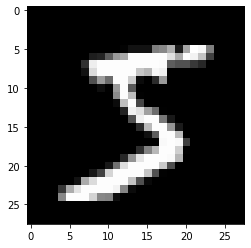

In [ ]:
plt.imshow(img);

## Matrix and tensor

In [ ]:
img[20][15]

0.98828125

In [ ]:
class Matrix:
    def __init__(self, xs): self.xs = xs
    def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [ ]:
m = Matrix(img)
m[20,15]

0.98828125

In [ ]:
import torch
from torch import tensor

In [ ]:
tensor([1,2,3])

tensor([1, 2, 3])

In [ ]:
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape

torch.Size([50000, 784])

In [ ]:
x_train.type()

'torch.FloatTensor'

[Tensor](https://pytorch.org/docs/stable/tensors.html)

In [ ]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

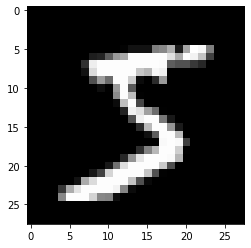

In [ ]:
plt.imshow(imgs[0]);

In [ ]:
imgs[0,20,15]

tensor(0.9883)

In [ ]:
n,c = x_train.shape
y_train, y_train.shape

(tensor([5, 0, 4,  ..., 8, 4, 8]), torch.Size([50000]))

In [ ]:
min(y_train),max(y_train)

(tensor(0), tensor(9))

In [ ]:
y_train.min(), y_train.max()

(tensor(0), tensor(9))

## Random numbers

Based on the Wichmann Hill algorithm used before Python 2.3.

In [ ]:
rnd_state = None
def seed(a):
    global rnd_state
    a, x = divmod(a, 30268)
    a, y = divmod(a, 30306)
    a, z = divmod(a, 30322)
    rnd_state = int(x)+1, int(y)+1, int(z)+1

In [ ]:
seed(457428938475)
rnd_state

(4976, 20238, 499)

In [ ]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [ ]:
rand(),rand(),rand()

(0.7645251082582081, 0.7920889799553945, 0.06912886811267205)

In [ ]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.9559050644103264
In child: 0.9559050644103264


In [ ]:
if os.fork(): print(f'In parent: {torch.rand(1)}')
else:
    print(f'In child: {torch.rand(1)}')
    os._exit(os.EX_OK)

In parent: tensor([0.6285])
In child: tensor([0.6285])


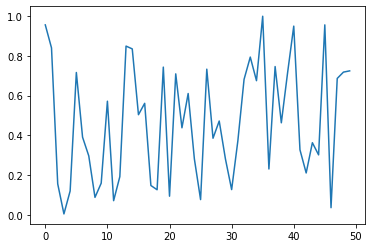

In [ ]:
plt.plot([rand() for _ in range(50)]);

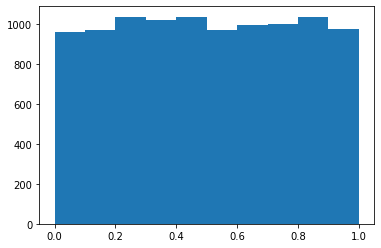

In [ ]:
plt.hist([rand() for _ in range(10000)]);

In [ ]:
%timeit -n 10 list(chunks([rand() for _ in range(7840)], 10))

5.17 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 5.49 times longer than the fastest. This could mean that an intermediate result is being cached.
219 µs ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix multiplication

In [ ]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [ ]:
m1 = x_valid[:5]
m2 = weights

In [ ]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
(ar,ac),(br,bc)

((5, 784), (784, 10))

In [ ]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [ ]:
for i in range(ar):         # 5
    for j in range(bc):     # 10
        for k in range(ac): # 784
            t1[i,j] += m1[i,k] * m2[k,j]

In [ ]:
t1

tensor([[ -2.0879,  11.0019,   0.6298,   3.3956,   4.6930,  17.1562,   9.1689,
          11.9809, -26.1469,   1.7197],
        [  7.9941,  15.4387,  10.3423,  12.6550,  11.0330,   3.3006,  10.1640,
          -6.9572, -17.1308,   0.6740],
        [ -6.7243,  -5.4895,   5.6803,  -0.4227,   2.0290,   3.3467,   6.8808,
           9.7617, -16.6106,   7.9772],
        [ 10.6607,  -8.5116,  -8.4777,   8.9876,   3.8719,   2.9791,   9.0135,
          -5.1871, -12.1824,   0.6104],
        [ -4.3070,  13.5034,  -7.0024,  -9.9511,  13.9137,   6.2566,   5.9713,
          -1.4399, -14.4829,   8.6138]])

In [ ]:
t1.shape

torch.Size([5, 10])

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
t1

tensor([[ -2.09,  11.00,   0.63,   3.40,   4.69,  17.16,   9.17,  11.98, -26.15,   1.72],
        [  7.99,  15.44,  10.34,  12.65,  11.03,   3.30,  10.16,  -6.96, -17.13,   0.67],
        [ -6.72,  -5.49,   5.68,  -0.42,   2.03,   3.35,   6.88,   9.76, -16.61,   7.98],
        [ 10.66,  -8.51,  -8.48,   8.99,   3.87,   2.98,   9.01,  -5.19, -12.18,   0.61],
        [ -4.31,  13.50,  -7.00,  -9.95,  13.91,   6.26,   5.97,  -1.44, -14.48,   8.61]])

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [ ]:
%time _=matmul(m1, m2)

CPU times: user 772 ms, sys: 5.23 ms, total: 777 ms
Wall time: 841 ms


## Numba

In [ ]:
from numba import njit

In [ ]:
@njit
def dot(a,b):
    res = 0.
    for i in range(len(a)): res+=a[i]*b[i]
    return res

In [ ]:
import numpy as np
from numpy import array

In [ ]:
dot(array([1.,2,3]),array([2.,3,4]))

20.0

Now only two of our loops are running in Python, not three:

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = dot(a[i,:], b[:,j])
    return c

In [ ]:
m1a,m2a = m1.numpy(),m2.numpy()

In [ ]:
from fastcore.test import *

In [ ]:
test_close(t1,matmul(m1a, m2a))

In [ ]:
%timeit -n 10 matmul(m1a,m2a)

498 µs ± 201 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Elementwise ops

[TryAPL](https://tryapl.org/)

In [ ]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [ ]:
a + b

tensor([12., 14.,  3.])

In [ ]:
(a < b).float().mean()

tensor(0.67)

In [ ]:
m = tensor([[1., 2, 3], [4,5,6], [7,8,9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

Frobenius norm:

$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$

*Hint*: you don't normally need to write equations in LaTeX yourself, instead, you can click 'edit' in Wikipedia and copy the LaTeX from there (which is what I did for the above equation). Or on arxiv.org, click "Download: Other formats" in the top right, then "Download source"; rename the downloaded file to end in `.tgz` if it doesn't already, and you should find the source there, including the equations to copy and paste. This is the source LaTeX that I pasted to render the equation above:

```latex
$$\| A \|_F = \left( \sum_{i,j=1}^n | a_{ij} |^2 \right)^{1/2}$$
```

In [ ]:
(m*m).sum().sqrt()

tensor(16.88)

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = (a[i,:] * b[:,j]).sum()
    return c

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

1.22 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc): c[i,j] = torch.dot(a[i,:], b[:,j])
    return c

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

925 µs ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

*This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of the fast.ai [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.*

### Broadcasting with a scalar

In [ ]:
a

tensor([10.,  6., -4.])

In [ ]:
a > 0

tensor([ True,  True, False])

How are we able to do `a > 0`?  0 is being **broadcast** to have the same dimensions as a.

For instance you can normalize our dataset by subtracting the mean (a scalar) from the entire data set (a matrix) and dividing by the standard deviation (another scalar), using broadcasting.

Other examples of broadcasting with a scalar:

In [ ]:
a + 1

tensor([11.,  7., -3.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
2*m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

### Broadcasting a vector to a matrix

Although broadcasting a scalar is an idea that dates back to APL, the more powerful idea of broadcasting across higher rank tensors [comes from](https://mail.python.org/pipermail/matrix-sig/1995-November/000143.html) a little known language called [Yorick](https://software.llnl.gov/yorick-doc/manual/yorick_50.html).

We can also broadcast a vector to a matrix:

In [ ]:
c = tensor([10.,20,30]); c

tensor([10., 20., 30.])

In [ ]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
m.shape,c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the rows, but it looks as if we did. In fact, the rows are given a *stride* of 0.

In [ ]:
t = c.expand_as(m)

In [ ]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [ ]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [ ]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use `unsqueeze()` to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [ ]:
c.unsqueeze(0), c[None, :]

(tensor([[10., 20., 30.]]), tensor([[10., 20., 30.]]))

In [ ]:
c.shape, c.unsqueeze(0).shape

(torch.Size([3]), torch.Size([1, 3]))

In [ ]:
c.unsqueeze(1), c[:, None]

(tensor([[10.],
         [20.],
         [30.]]),
 tensor([[10.],
         [20.],
         [30.]]))

In [ ]:
c.shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

In [ ]:
c[None].shape,c[...,None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [ ]:
c[:,None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [ ]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [ ]:
m + c[None,:]

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

### Broadcasting Rules

In [ ]:
c[None,:]

tensor([[10., 20., 30.]])

In [ ]:
c[None,:].shape

torch.Size([1, 3])

In [ ]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [ ]:
c[:,None].shape

torch.Size([3, 1])

In [ ]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [ ]:
c[None] > c[:,None]

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

When operating on two arrays/tensors, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1, in which case that dimension is broadcasted to make it the same size

Arrays do not need to have the same number of dimensions. For example, if you have a `256*256*3` array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

The [numpy documentation](https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html#general-broadcasting-rules) includes several examples of what dimensions can and can not be broadcast together.

### Matmul with broadcasting

In [ ]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:] * b[:,j]).sum()      # previous version
        c[i]   = (a[i,:,None] * b).sum(dim=0) # broadcast version
    return c

In [ ]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [ ]:
m1[0,:,None].shape, m2.shape

(torch.Size([784, 1]), torch.Size([784, 10]))

In [ ]:
test_close(t1,matmul(m1, m2))

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

288 µs ± 65 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

In [ ]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [ ]:
%timeit -n 10 _=matmul(m1, m2)

57.2 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
885000/55

16090.90909090909

In [ ]:
test_near(t1, matmul(m1, m2))

### pytorch op

We can use pytorch's function or operator directly for matrix multiplication.

In [ ]:
%timeit -n 10 t2 = m1.matmul(m2)

18.2 µs ± 6.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
t2 = m1@m2

In [ ]:
test_near(t1, t2)

In [ ]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))